## Outliers 2

Outliers are data points that we dont want to consider in our fit. The reasons can be different. It might be spurious signal falling on the detector, like glitches, or in principle valid signal that cannot be considered in the model at hand.

Here we present the same data as in the methanol example. See there for explanation of the construction of the spectrum. 

Part of that spectrum (around 500 GHz) shows a sinusoidal background signal, which is caused by aliasing in the deconvolution process. 

We want to fit the background with a sine function. All absorption lines in the spectrum are outliers and should be disregarded.

In this example we use the NestedSampler with a mixture of 2 error distributions: Gauss and Uniform

Demonstration: 
1. Compound model of sine + constant
2. NestedSampler 
3. MixedErrorDistribution: Gauss + Uniform

Author: Do Kester


We need to import some classes

In [1]:
import numpy as numpy
import math

from astropy.io import fits
from BayesicFitting import SineModel
from BayesicFitting import PolynomialModel
from BayesicFitting import NestedSampler
from BayesicFitting import MixedErrorDistribution
from BayesicFitting import GaussErrorDistribution
from BayesicFitting import UniformErrorDistribution
from BayesicFitting import formatter as fmt
from BayesicFitting import Tools
from BayesicFitting import plotFit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
# uncomment the next line to get the plots in a separate scalable 
# window.

#%matplotlib osx

#%matplotlib inline

Read the data

In [3]:
hdu = fits.open( "data/Decgf-Methanol-1-5.fits" )

In [4]:
data = hdu[1].data
flux = data.field( 0 )
freq = data.field( 1 )
covr = data.field( 2 )


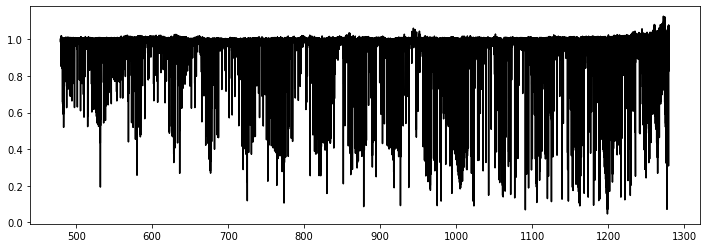

In [5]:
plt.figure( "complete", figsize=(12,4) )
plt.plot( freq, flux, 'k-')
plt.show()


Select the part between 490 and 560 GHz, where the background is aliased.

140000


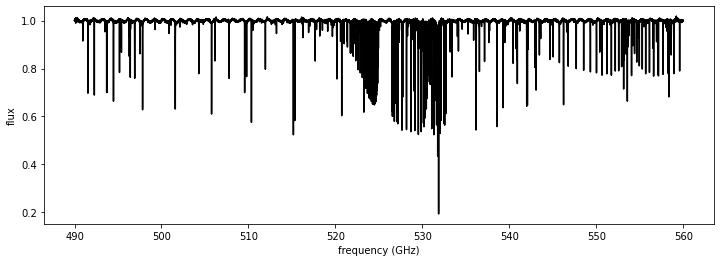

In [6]:
q = numpy.where( numpy.logical_and( freq > 490, freq < 560 ))
flx = flux[q]
frq = freq[q]
cov = covr[q]
print( len( flx ) )
plt.figure( "490 to 560", figsize=(12,4) )
plt.plot( frq, flx, 'k-')
plt.ylabel( "flux" )
plt.xlabel( "frequency (GHz)" )

plt.show()


Make a compound model consisting of a SineModel plus a constant: PolynomialModel( 0 ).

In [7]:
sm = SineModel()
lo = [0.9, -0.2, -0.2]
hi = [1.1, 0.2,  0.2]
sm.setLimits( lo, hi )
pm = PolynomialModel( 0 )
pm.setLimits( [0.99], [1.01] )
model = pm + sm


Construct a mixed error distribution consisting of a Gaussian kernel which should catch the sinusoidal background plus a broad Uniform error distribution that should catch and neutralize the absorption lines.

In [8]:
ged = GaussErrorDistribution( limits=[0.001,1])
ued = UniformErrorDistribution( limits=[0.1,10] )
ed = MixedErrorDistribution( ged, ued, limits=[0.1,0.9] )

#Tools.printclass( ed )
#Tools.printclass( ed.hyperpar[-1] )
#Tools.printclass( ed.hyperpar[-2] )
#Tools.printclass( ed.hyperpar[-3] )

ns = NestedSampler( frq, model, flx, distribution=ed, seed=2233 )
ns.verbose = 1

evidence = ns.sample( )
pars = ns.parameters
#print( pars )
#print( ns.stdevs )
#print( ns.scale )
#print( evidence )

Fit all parameters of
  Polynomial: f( x:p ) = p_0 +
  Sine: f( x:p ) = p_2 * cos( 2PI * x * p_1 ) + p_3 * sin( 2PI * x * p_1 )
Using a Mixed error distribution : Gauss + Uniform with unknown hypar
Moving the walkers with   GalileanEngine  ChordEngine
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>
Iteration     logZ        H       LowL     npar
   10490   5.22e+05     91.2   5.22e+05      7 
Parameters   [    0.999    1.000    0.004    0.003    0.003    0.803    0.900]
Engines              success     reject     failed       best      calls
GalileanEngine         85934      28767      32312          0      10490
ChordEngine            73725     326984          0          0      10490
Calls to LogL         576489   to dLogL      28767
Samples       10590
Evidence    226509.350 +-      0.415


In [9]:
sl = ns.samples
param = sl.parameters
stdev = sl.stdevs
hypar = sl.hypars
sthyp = sl.stdevHypars
print( "Params ", fmt( param, max=None, format=" %10.5f" ) )
print( "Stdevs ", fmt( stdev, max=None, format=" %10.5f" ) )
print( "Hypars ", fmt( hypar, max=None, format=" %10.5f" ) )
print( "StdHyp ", fmt( sthyp, max=None, format=" %10.7f" ) )


Params  [    0.99945    0.99976    0.00364    0.00307]
Stdevs  [    0.00001    0.00001    0.00009    0.00010]
Hypars  [    0.00286    0.80309    0.89990]
StdHyp  [  0.0000074  0.0000736  0.0001056]


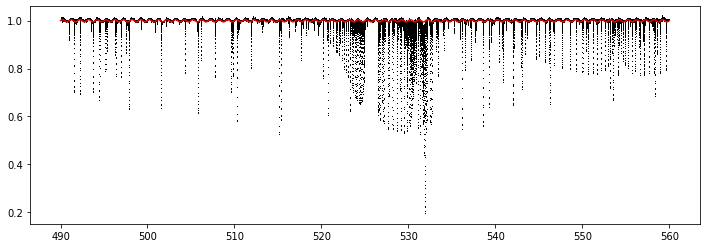

In [10]:
yfit = model.result( frq, param )
plt.figure( 1, figsize=(12,4) )
plt.plot( frq, flx, 'k,' )
plt.plot( frq, yfit, 'r-' )
plt.show()